# Log-normal Mocks

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('cookbook.mplstyle')

In [2]:
from nbodykit.lab import *
from nbodykit import setup_logging

In [3]:
setup_logging() # turn on logging to screen

## Initalizing the Log-normal Mock

Here, we generate a mock catalog of biased objects ($b_1 = 2$ ) at a redshif $z=0.55$. We use the *Planck 2015* cosmology and the Eisenstein-Hu linear power spectrum fitting formula. 

We generate the catalog in a box of side length $L = 1380 \ \mathrm{Mpc}/h$ with a constant number density $\bar{n} = 3 \times 10^{-3} \ h^{3} \mathrm{Mpc}^{-3}$.

In [4]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.EHPower(cosmo, redshift)
b1 = 2.0

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=1380., Nmesh=256, bias=b1, seed=42)

[ 000013.94 ]   0: 07-29 14:17  CatalogSource   INFO     total number of particles in LogNormalCatalog(seed=42, bias=2) = 7883861


## Real-space Power Spectrum


In this section, we compute and plot the power spectrum, $P(k,\mu)$, in real space (no redshift distortions) using five $\mu$ bins. 

In [5]:
# convert the catalog to the mesh, with CIC interpolation 
real_mesh = cat.to_mesh(compensated=True, window='cic')

# compute the 2d P(k,mu) power, with 5 mu bins
r = FFTPower(real_mesh, mode='2d', Nmu=5)
pkmu = r.power

[ 000016.56 ]   0: 07-29 14:17  CatalogMeshSource INFO     total number of particles in (LogNormalCatalog(seed=42, bias=2) as CatalogMeshSource) = 7883861
[ 000019.15 ]   0: 07-29 14:17  CatalogMeshSource INFO     mean particles per cell is 0.469915
[ 000019.15 ]   0: 07-29 14:17  CatalogMeshSource INFO     sum is 7.88386e+06 
[ 000019.15 ]   0: 07-29 14:17  CatalogMeshSource INFO     normalized the convention to 1 + delta
[ 000019.50 ]   0: 07-29 14:17  FFTPower        INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMeshSource) painting done


(500, 200000.0)

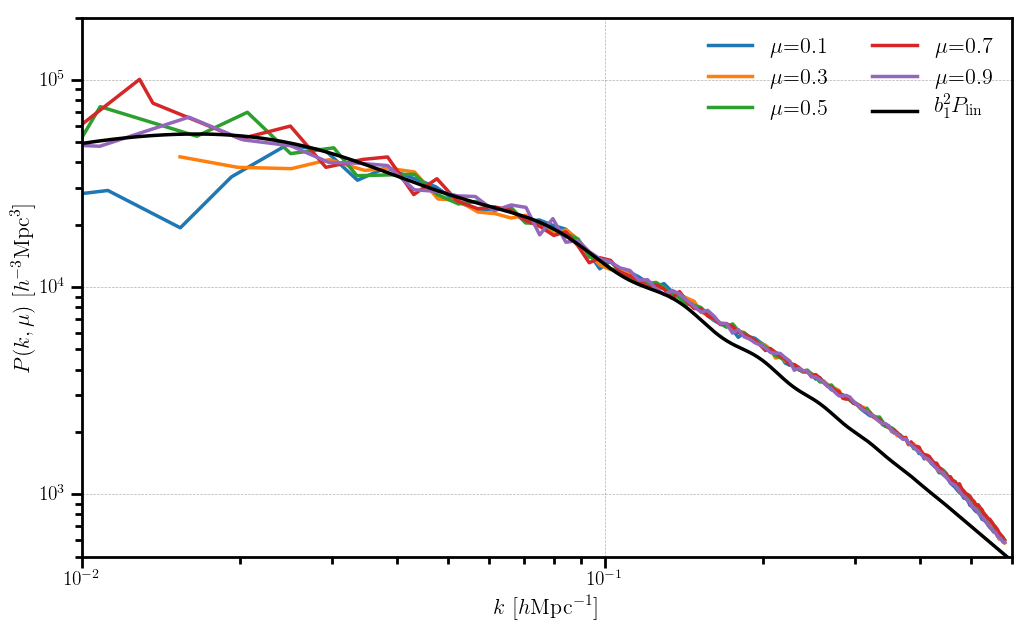

In [6]:
# plot each mu bin
for i in range(pkmu.shape[1]):
    Pk = pkmu[:,i]
    label = r'$\mu$=%.1f' %pkmu.coords['mu'][i]
    plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)

# plot the biased linear power spectrum
k = numpy.logspace(-2, 0, 512)
plt.loglog(k, b1**2 * Plin(k), c='k', label=r'$b_1^2 P_\mathrm{lin}$')

# add a legend and axes labels
plt.legend(loc=0, ncol=2, fontsize=16)
plt.xlabel(r"$k$ [$h \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3} \mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)
plt.ylim(500, 2e5)

In this figure, we see the power spectrum in real-space is independent of $\mu$, as expected. At low $k$, the measured power agrees with the biased linear power $b_1^2 P_\mathrm{lin}$. But at high $k$, we see the effects of applying the Zel'dovich approximation to the density field, mirroring the effects of nonlinear evolution.

## Redshift-space Power Spectrum

In this section, we compute and plot the power spectrum, $P(k,\mu)$, in redshift space and see the effects of redshift-space distortions on the 2D power spectrum. 

In [7]:
def kaiser_pkmu(k, mu):
    """
    Returns the Kaiser linear P(k,mu) in redshift space
    
    .. math:: 
    
        P(k,mu) = (1 + f/b_1 mu^2)^2 b_1^2 P_\mathrm{lin}(k)
    """
    beta = cosmo.growth_rate(redshift) / b1
    return (1 + beta*mu**2)**2 * b1**2 * Plin(k)

Here, we add redshift space distortions (RSD) along the $z$-axis of the box. We use the ``VelocityOffset`` column which is equal to the ``Velocity`` column re-normalized properly for RSD. 

In [8]:
LOS = [0,0,1] # the z-axis

# add RSD to the Position
cat['Position'] += cat['VelocityOffset'] * LOS

[ 000022.37 ]   0: 07-29 14:17  CatalogMeshSource INFO     total number of particles in (LogNormalCatalog(seed=42, bias=2) as CatalogMeshSource) = 7883861
[ 000025.31 ]   0: 07-29 14:17  CatalogMeshSource INFO     mean particles per cell is 0.469915
[ 000025.31 ]   0: 07-29 14:17  CatalogMeshSource INFO     sum is 7.88386e+06 
[ 000025.31 ]   0: 07-29 14:17  CatalogMeshSource INFO     normalized the convention to 1 + delta
[ 000025.68 ]   0: 07-29 14:17  FFTPower        INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMeshSource) painting done


(0, 2.5)

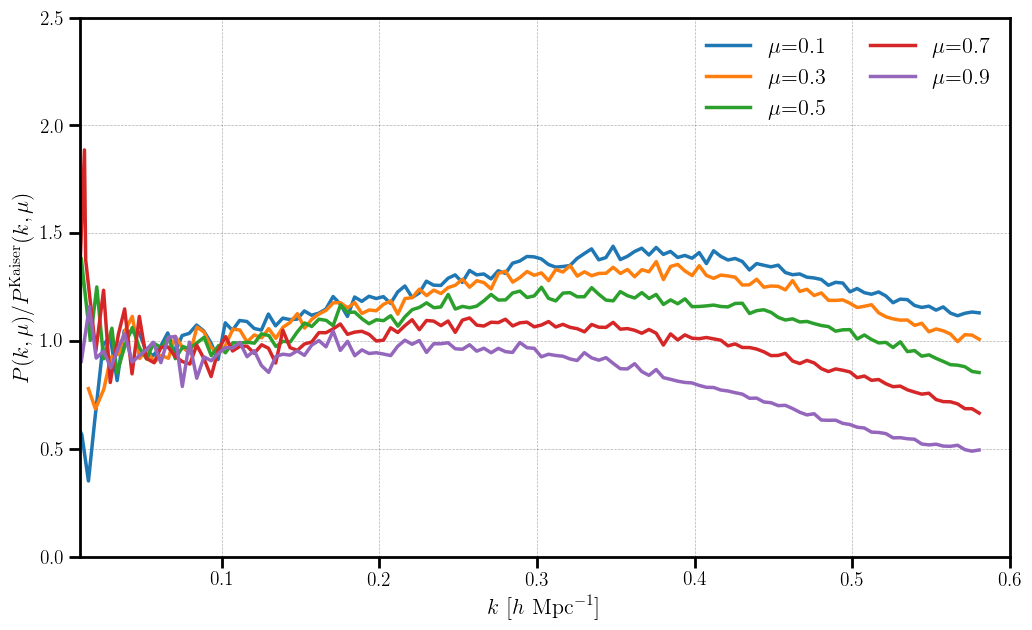

In [9]:
# from catalog to mesh
rsd_mesh = cat.to_mesh(compensated=True, window='cic')

# compute the 2D power
r = FFTPower(rsd_mesh, mode='2d', Nmu=5, los=LOS)
pkmu = r.power

# plot each mu power bin, normalized by the expected Kaiser power
for i in range(pkmu.shape[1]):
    Pk = pkmu[:,i]
    mu = pkmu.coords['mu'][i]
    label = r'$\mu$=%.1f' %mu
    
    P = Pk['power'].real-Pk.attrs['shotnoise']
    plt.plot(Pk['k'], P / kaiser_pkmu(Pk['k'], mu), label=label)

# add a legend and axis labels
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu) / P^\mathrm{Kaiser}(k,\mu)$")
plt.xlim(0.01, 0.6)
plt.ylim(0, 2.5)

In this figure, we clearly see the effects of RSD, which causes the higher $\mu$ bins to be damped at high $k$, relative to the lower $\mu$ bins. Also, the measured power agrees with the expected Kaiser formula for linear RSD at low $k$ (where linear theory holds): $P^\mathrm{Kaiser} = (1 + f/b_1 \mu^2)^2 b_1^2 P_\mathrm{lin}(k)$. 